## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from torch import optim
from IPython.display import clear_output
from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4,palette='Set2')
np.random.seed(42)

%config InlineBackend.figure_format="retina"
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)

train_set, val_set = torch.utils.data.random_split(fmnist_dataset_train, [50000, 10000])

fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, 
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=128,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
print('Test size', len(fmnist_dataset_test))
print('Train size', len(fmnist_dataset_train))

Test size 10000
Train size 60000


In [6]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
          nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Dropout(0.2),

          nn.Flatten(),
          nn.Linear(14 * 14 * 16, 128), # After pooling 28 / 2 = 14, 16 channels
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(128, num_classes),
        )
              
    def forward(self, inp):       
        return self.model(inp)

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           6,416
       BatchNorm2d-5           [-1, 16, 28, 28]              32
              ReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
           Dropout-8           [-1, 16, 14, 14]               0
           Flatten-9                 [-1, 3136]               0
           Linear-10                  [-1, 128]         401,536
      BatchNorm1d-11                  [-1, 128]             256
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

Your experiments come here:

In [9]:
def accuracy(model, loader):
  true_hits =  torch.empty(0)
  true_hits = true_hits.to(device)
  model.eval()
  with torch.no_grad():
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        y_pred = model(imgs)
        pred_classes = torch.argmax(y_pred, dim=-1)
        true_hits = torch.cat((
            true_hits, 
            (pred_classes == labels).sum().unsqueeze(0)
        ))
  return (true_hits.sum() / true_hits.size(0) / loader.batch_size).item()

In [10]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=5):
    train_loss, train_acc, val_loss, val_acc = [], [], [], []
    
    for epoch in range(n_epochs):
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        train_epoch_loss, train_epoch_true_hits = train_epoch_loss.to(device), train_epoch_true_hits.to(device)
        model.train()
        for imgs, labels in tqdm(train_dataloader, desc=f"Training, epoch {epoch}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_epoch_loss = torch.cat((train_epoch_loss, loss.unsqueeze(0)))

            pred_classes = torch.argmax(y_pred, dim=-1)
            train_epoch_true_hits = torch.cat((
                train_epoch_true_hits, 
                (pred_classes == labels).sum().unsqueeze(0)
            ))
        
        train_loss.append(train_epoch_loss.mean().item())
        train_acc.append((train_epoch_true_hits.sum() / train_epoch_true_hits.size(0) / train_dataloader.batch_size).item())


        # validation
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        val_epoch_loss, val_epoch_true_hits = val_epoch_loss.to(device), val_epoch_true_hits.to(device)

        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(val_dataloader, desc=f"Validating, epoch {epoch}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                
                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat((val_epoch_loss, loss.unsqueeze(0)))

                pred_classes = torch.argmax(y_pred, dim=-1)
                val_epoch_true_hits = torch.cat((
                    val_epoch_true_hits,
                    (pred_classes == labels).sum().unsqueeze(0)
                ))
        
        
        val_loss.append(val_epoch_loss.mean())
        val_acc.append((val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size).item())

        clear_output(wait=True)
        print("Train loss:", train_epoch_loss.mean().item())
        print("Train acc:", (train_epoch_true_hits.sum() / train_epoch_true_hits.size(0) / train_dataloader.batch_size).item())
        print("Val loss:", val_epoch_loss.mean().item())
        print("Val acc:", (val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size).item())
    return train_loss, train_acc, val_loss, val_acc

In [11]:
def plot_learning_curve(train_loss, train_acc, val_loss, val_acc, plt_label):
    fig, ax = plt.subplots(1, 2, figsize=(19, 8))
    plt.suptitle(plt_label, fontsize=18)
 
    ax[0].set_title('Loss')
    ax[0].plot(train_loss, label='Train')
    ax[0].plot(val_loss, label='Validation')
    ax[0].legend()


    ax[1].set_title('Accuracy')
    ax[1].plot(train_acc, label='Train')
    ax[1].plot(val_acc, label='Validation')
    ax[1].legend()
    plt.show()

In [17]:
model = TinyNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=1e-2)
loss_func = nn.CrossEntropyLoss()

train_loss, train_acc, val_loss, val_acc = train(
    model, loss_func, opt, train_loader, val_loader, n_epochs=20)

Train loss: 0.12885072827339172
Train acc: 0.949188768863678
Val loss: 0.21046899259090424
Val acc: 0.9183148741722107


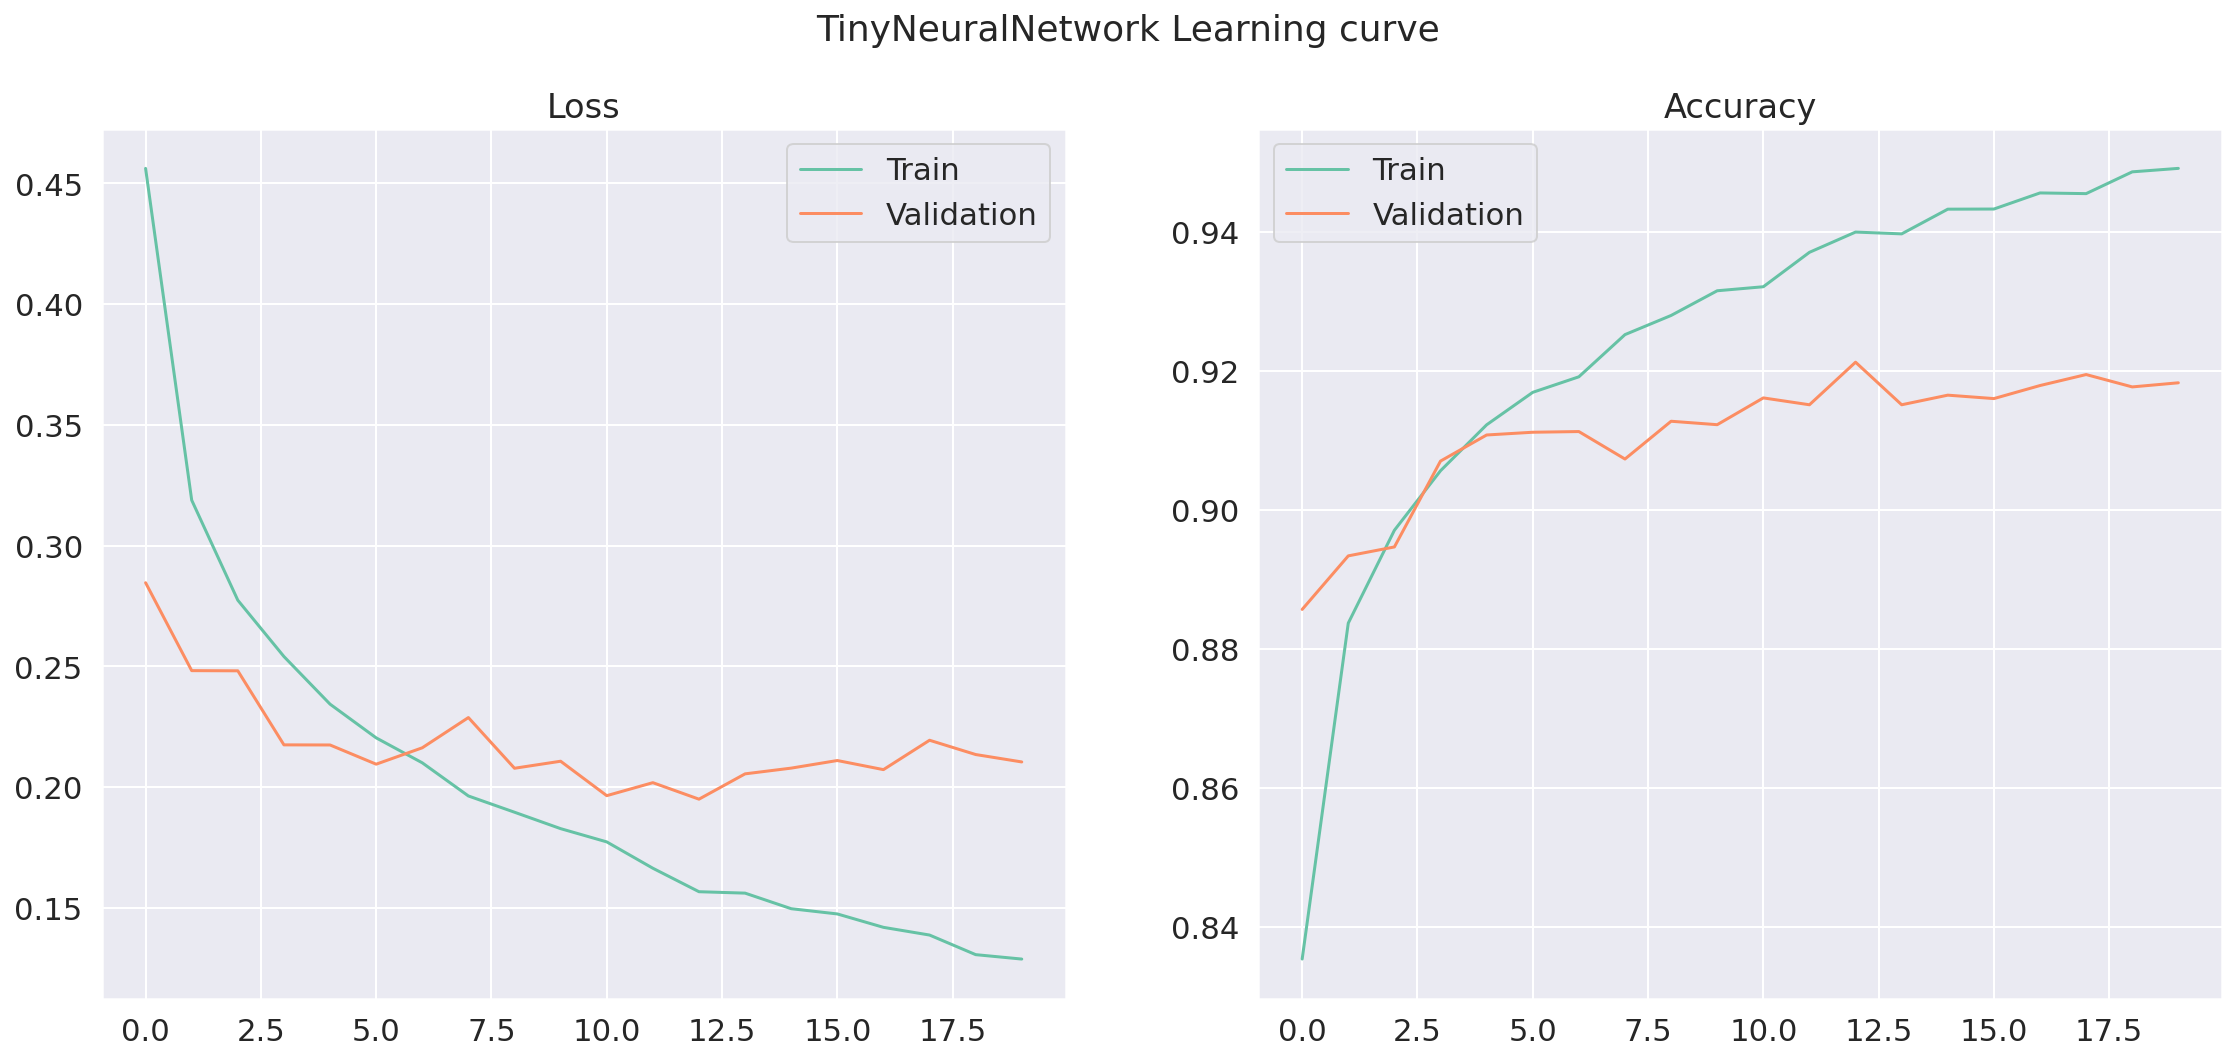

In [18]:
plot_learning_curve(
    train_loss, train_acc, val_loss, val_acc, 
    'TinyNeuralNetwork Learning curve')

In [19]:
print('Test accuracy', accuracy(model, test_loader))

Test accuracy 0.918117105960846


__Вывод:__ как видим с с примерно 5-6 эпохи лосс на валидации стабилизируется, возможно это из-за плохо выбора learning rate, но покрутив его немного ничего особо приципиально не менялось, поэтому я оставил как есть. Но он хотя бы не растет с ростом эпохи, так что считаю уже неплохо. 

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [20]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(28 * 28 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )
        
    def forward(self, inp):
        return self.model(inp)

In [21]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           6,416
              ReLU-4           [-1, 16, 28, 28]               0
           Flatten-5                [-1, 12544]               0
            Linear-6                  [-1, 512]       6,423,040
              ReLU-7                  [-1, 512]               0
            Linear-8                  [-1, 256]         131,328
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 6,563,514
Trainable params: 6,563,514
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.49
Params size (MB): 25.04
Estima

Оставим только 25% данных для обучения.

In [22]:
inds = np.random.choice(len(train_set), size=int(0.25 * len(train_set)), replace=False)
dicreased_train_set = torch.utils.data.Subset(train_set, inds)
dec_train_loader = torch.utils.data.DataLoader(dicreased_train_set, 
                                              batch_size=128,
                                              shuffle=True,
                                              num_workers=2)
len(dicreased_train_set)

12500

In [23]:
overfitting_model = OverfittingNeuralNetwork().to(device)
opt = optim.Adam(overfitting_model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

train_loss, train_acc, val_loss, val_acc = train(
    overfitting_model, loss_func, opt, dec_train_loader, val_loader, n_epochs=20)

Train loss: 0.0008245549979619682
Train acc: 0.9964126348495483
Val loss: 0.7543639540672302
Val acc: 0.8857793211936951


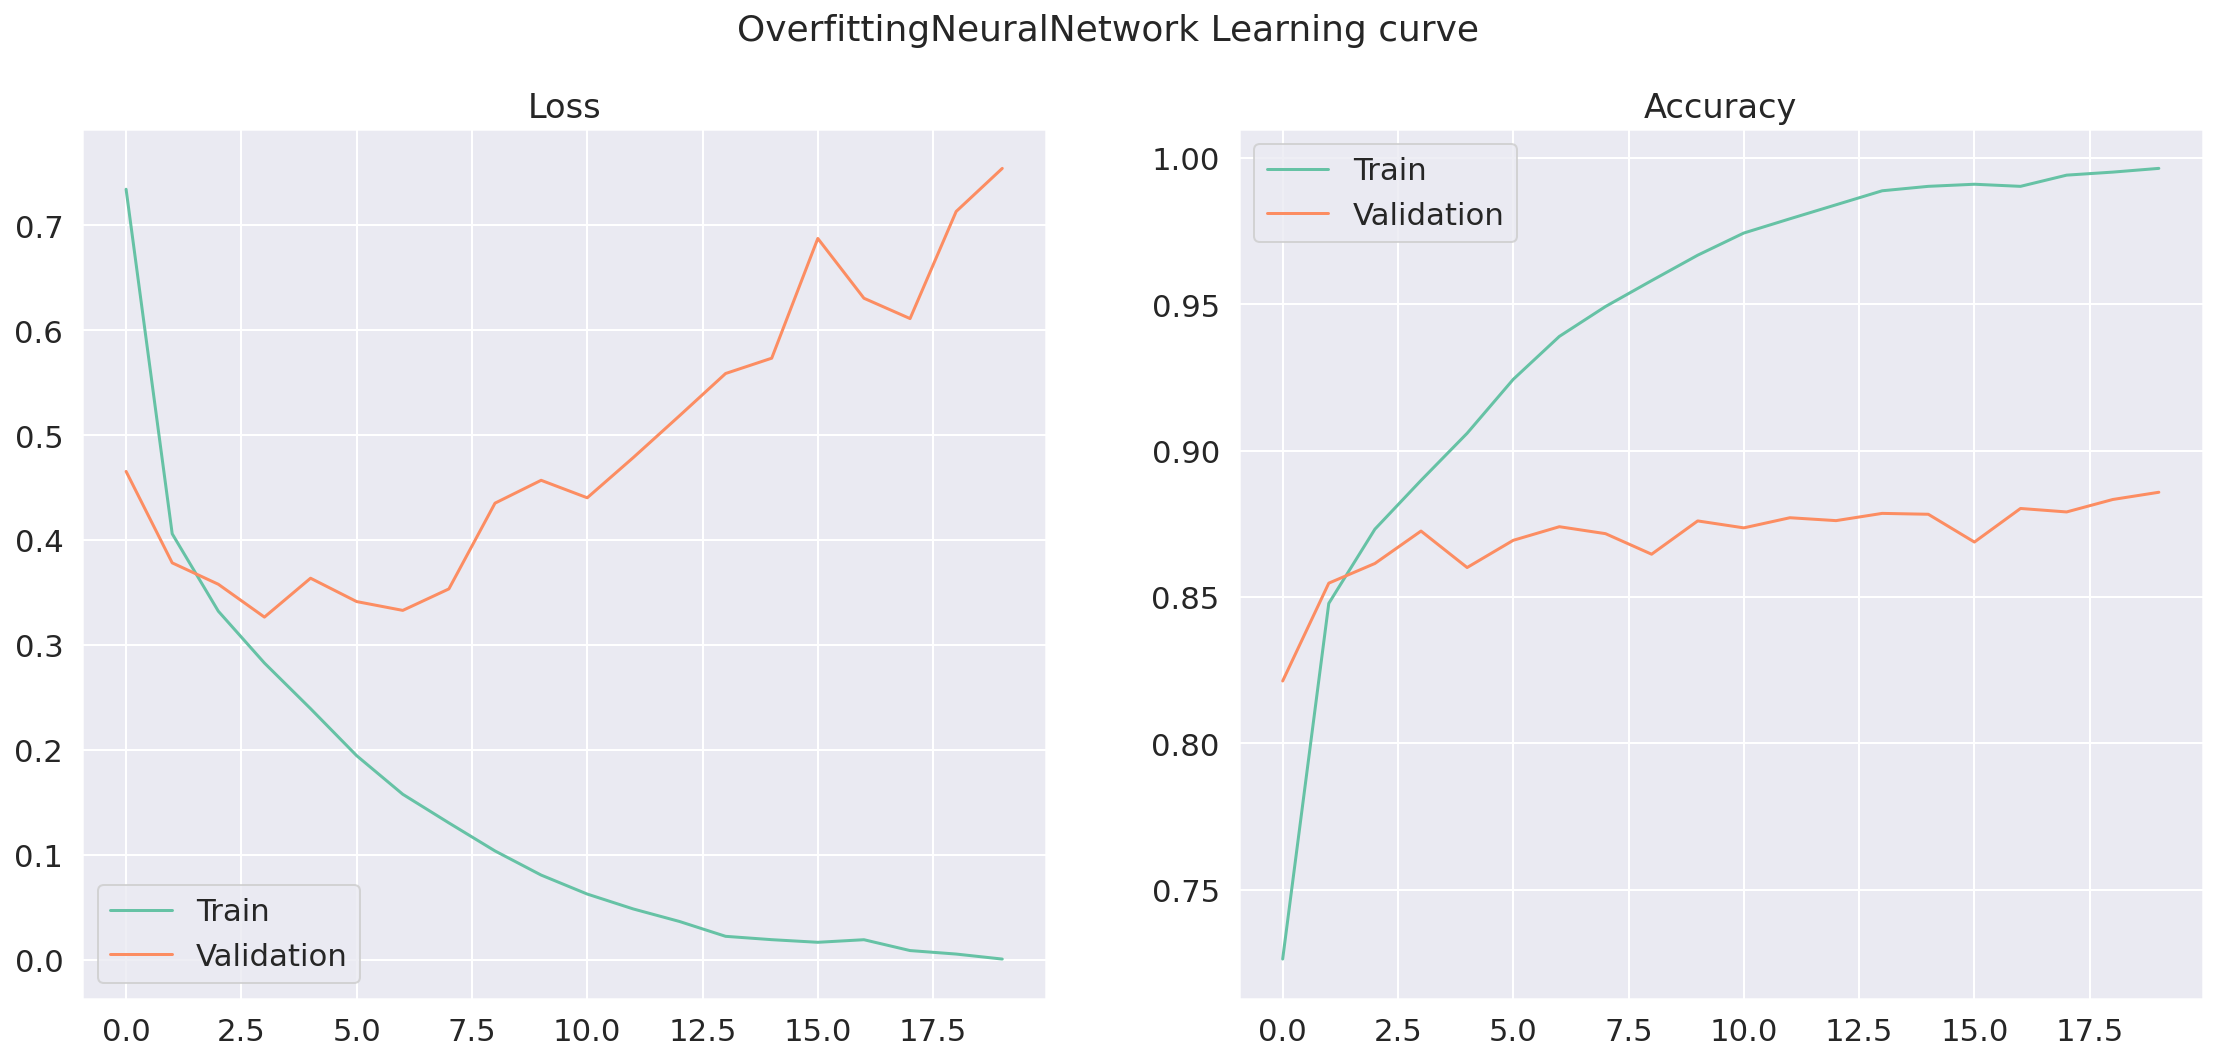

In [24]:
plot_learning_curve(
    train_loss, train_acc, val_loss, val_acc, 
    'OverfittingNeuralNetwork Learning curve')

In [25]:
print('Test accuracy', accuracy(overfitting_model, test_loader))

Test accuracy 0.8775712251663208


__Вывод__ Как видно из графика примерно с 5-ой эпохи лосс на валидации начал расти, причем достаточно сильно, в отличие от лосса на обучении, который падал с увелечением эпохи причем в отличие от предыдущего случая за 20 эпох стал почти нулевым. Это все, конечно же, говорит о высокой степени переобучения сети. Accuracy как следствие тоже неплохо упал.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [26]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.Flatten(),
            nn.Linear(14 * 14 * 16, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [27]:
torchsummary.summary(FixedNeuralNetwork().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           6,416
       BatchNorm2d-5           [-1, 16, 28, 28]              32
              ReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
           Dropout-8           [-1, 16, 14, 14]               0
           Flatten-9                 [-1, 3136]               0
           Linear-10                  [-1, 512]       1,606,144
      BatchNorm1d-11                  [-1, 512]           1,024
             ReLU-12                  [-1, 512]               0
          Dropout-13                  [-1, 512]               0
           Linear-14                  [

In [31]:
fixed_model = FixedNeuralNetwork().to(device)
opt = optim.Adam(fixed_model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

train_loss, train_acc, val_loss, val_acc = train(
    fixed_model, loss_func, opt, train_loader, val_loader, n_epochs=20)

Train loss: 0.09158814698457718
Train acc: 0.9659526944160461
Val loss: 0.22005628049373627
Val acc: 0.9210838675498962


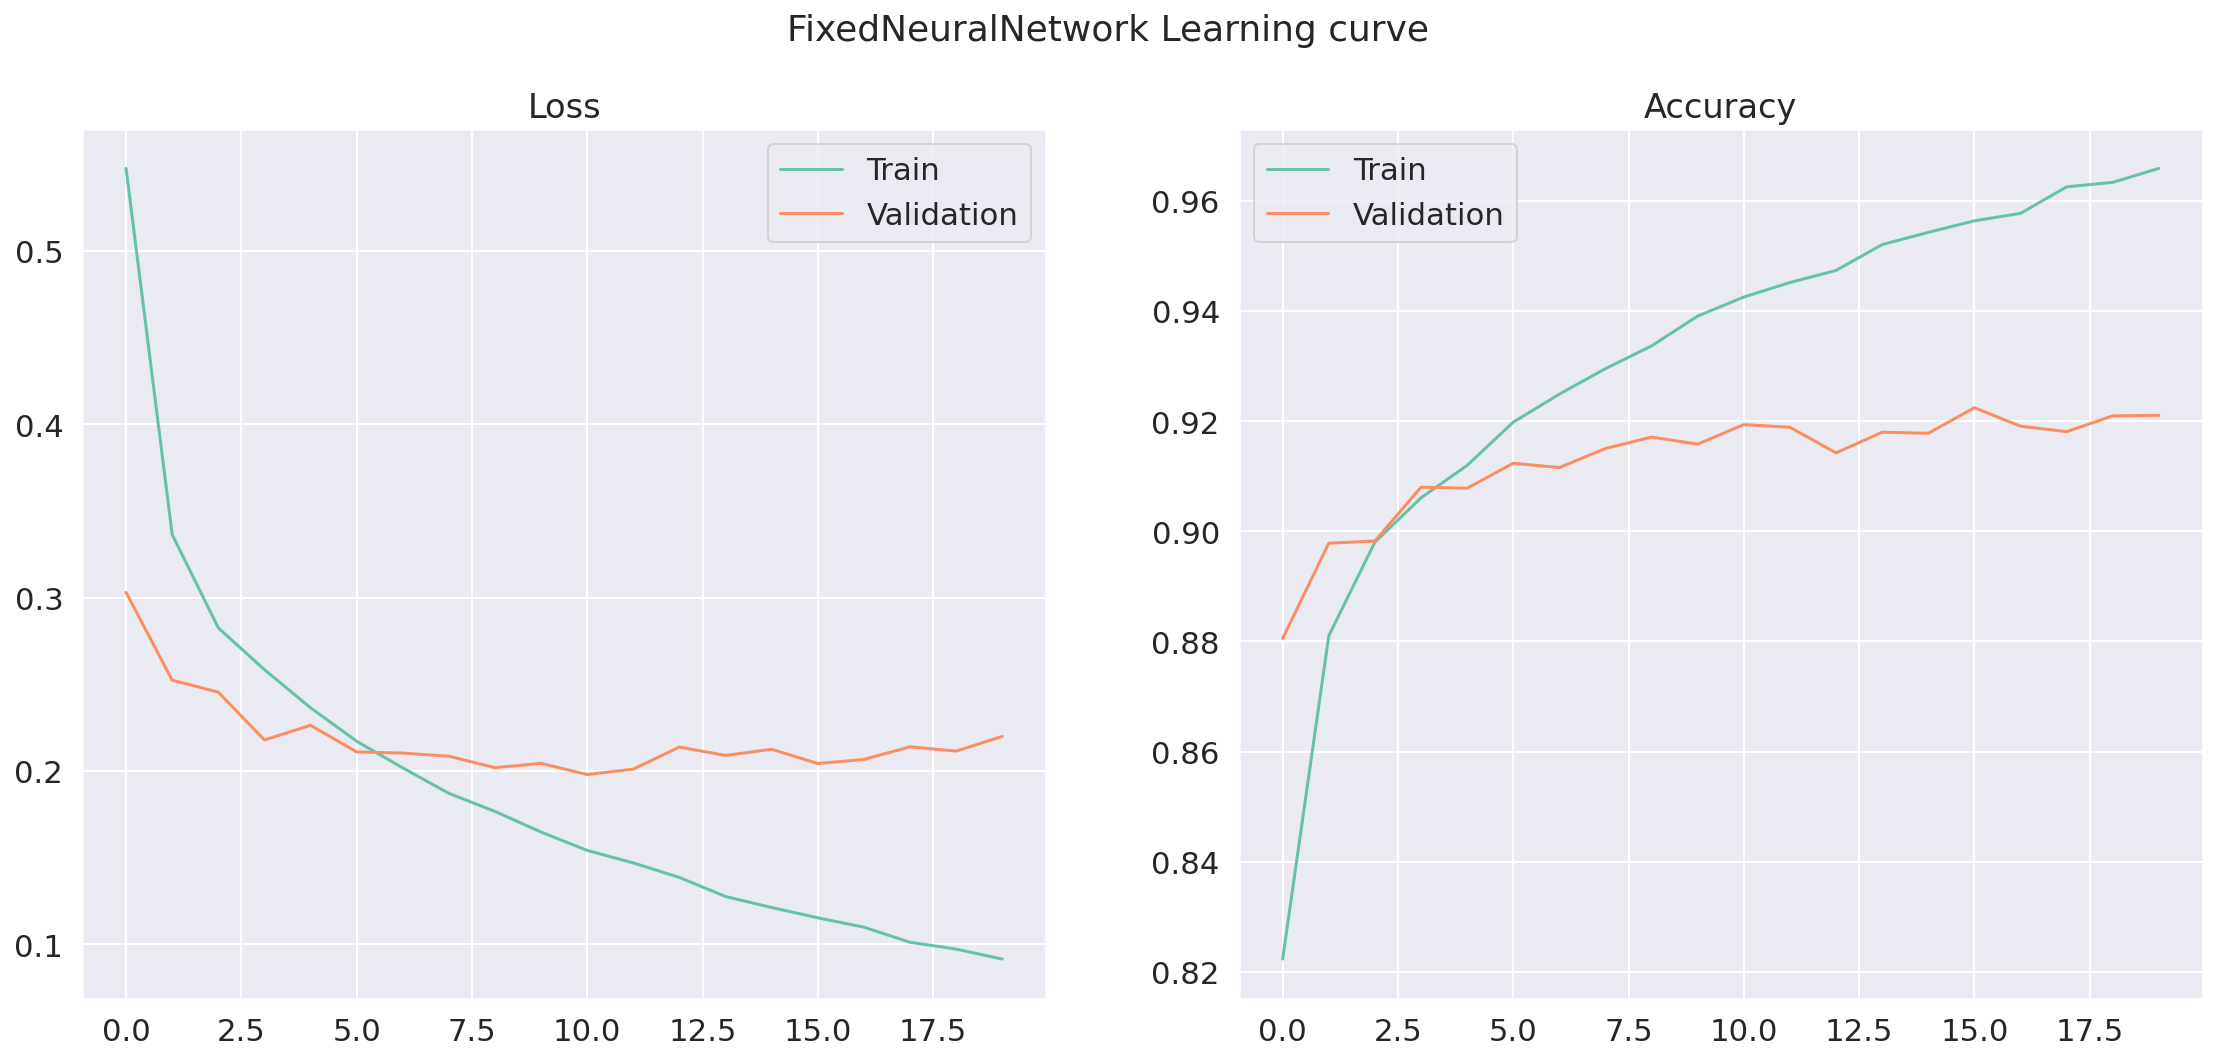

In [32]:
plot_learning_curve(
    train_loss, train_acc, val_loss, val_acc, 
    'FixedNeuralNetwork Learning curve')

In [30]:
print('Test accuracy', accuracy(fixed_model, test_loader))

Test accuracy 0.9197982549667358


### Conclusions:
Все архитектуры сетей получились похожими, по сути я взял один VGG-16 блок и 2-3 полносвязных слоя и немного подкручивал у них параметры. Для того чтобы показать переобучение, я просто добавил один FC слой и увеличил количество параметров в них. После добавления Dropout-а и BatchNorm-а мы видим как ситуация улучшилась, во первых лосс на валидации перестал расти, а на трейне он не убежал в 0 за 20 эпох, итоговый accuracy на тесте тоже стал получше.

Нормально ли что лосс на валидации стабилизируется примерно на отметке в 0.2 я так не смог выяснить. Как уже описывал, очень возможно, что это проблема плохо выбранного learning rate. Я попробовал его подкрутить, но на всех значениях который попробовал картина примерно одинаковая, поэтому оставил как есть.